In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant    
import scipy.stats as stats
import missingno as msno
from sklearn.ensemble import IsolationForest

# Mesure de l'hétéroscedasticité
import statsmodels.api as sm
import statsmodels.stats.api as sms

import warnings

dataset = pd.read_csv("sets/train.csv")
df = dataset.copy()

pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings("ignore")

# **Exploratory Data Analysis (EDA)**
## **1. Checklist de base**
## - Basic Exploration :
- ### Variable target :
  - Type : `df[target].dtypes` : int64
  - Distribution des classes : Vérifier si les classes sont déséquilibrées (classification) ou si la cible est bien répartie.
  - Résumé statistique : `df[target].describe()` :


In [50]:
print(df["trip_duration"].describe())

count   1458644.00
mean        959.49
std        5225.74
min           1.00
25%         397.00
50%         662.00
75%        1075.00
max     3526282.00
Name: trip_duration, dtype: float64


- ### Lignes et colonnes :
  - Nombre de lignes et de colonnes : `df.shape` : (1458644, 11)
  - Données uniques / redondantes : `df.columns.duplicated()` : aucune


In [9]:
print(df.shape)
print(df.columns.duplicated())

(1458644, 11)
[False False False False False False False False False False False]


- ### Types de variables :
  - Catégorielles : 2
  - Continues : 7
  - Dates / Temps : 2

In [10]:
print(df.info())
print(df['id'].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
0    id2875421
1    id2377394
2    id3858529
3    id3504673
4    id2181028
Name: id, dtype: object


- ### Analyse de valeurs manquantes (heatmap) :
  - Proportions par colonnes : aucune
  - Méthodes de gestion :     
    - Supression :     
    - Imputation :    


id                   0.00
vendor_id            0.00
pickup_datetime      0.00
dropoff_datetime     0.00
passenger_count      0.00
pickup_longitude     0.00
pickup_latitude      0.00
dropoff_longitude    0.00
dropoff_latitude     0.00
store_and_fwd_flag   0.00
trip_duration        0.00
dtype: float64


<Axes: >

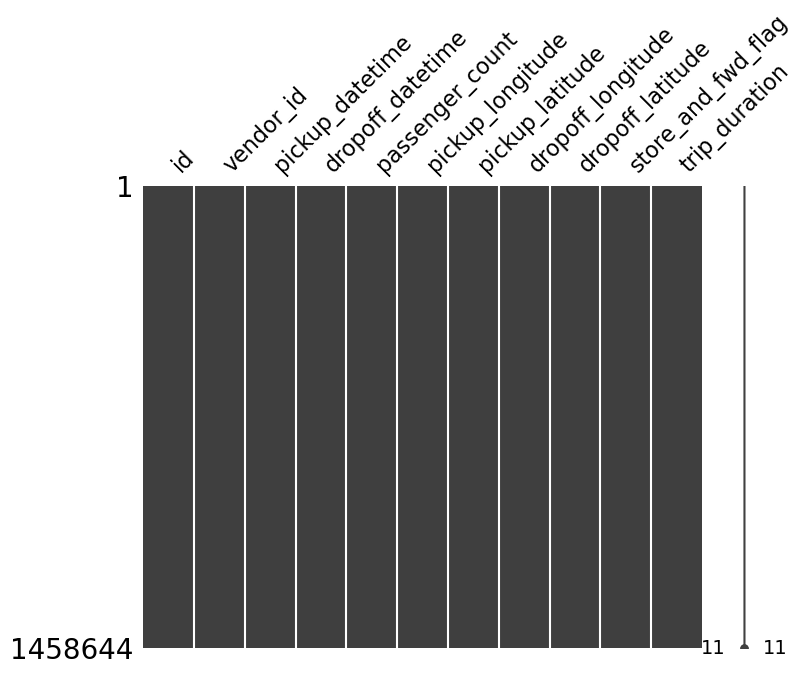

In [11]:
nan_value = df.isna().sum()/df.shape[0]
print(nan_value)
msno.matrix(df, figsize=(8, 6))

- ### Analyse des outliers (IQR, Z-score, boxplot) :
  - Proportions par colonnes (IQR) : 104113 
    - passenger_count :  0.033138997589542064
    - pickup_longitude :  0.00025160354411357395
    - pickup_latitude :  0.02300972684219042
    - dropoff_longitude :  0.001696095825986327
    - dropoff_latitude :  0.011858959417102459
    - trip_duration :  0.0014211829617096427
  - Observations : 
    - l'IQR détecte beaucoup d'ouliers, distributions asymétriques
    - beaucoup de Z-Score élevé (97459), ce qui indique des distributions asymétriques
    - l'IsolationForest ne détecte aucun outliers, dans ce cas, c'est cette métrique la plus fiable dû aux distributions asymétriques

  - Méthodes de gestion :
    - Supression : aucune
    - Imputation : aucune


In [2]:
continuous_features = df.select_dtypes(exclude=["object", "datetime"]).columns.drop("vendor_id")

def outliers_detection(df):
    # liste d'anomalies
    anomalies = []

    # Limite supérieur et inférieur à 3 écarts types
    data_std = statistics.stdev(df)
    data_mean = statistics.mean(df)
    anomaly_cut_off = data_std * 3

    lower_limit = data_mean - anomaly_cut_off
    upper_limit = data_mean + anomaly_cut_off

    # Génère les outliers
    for outlier in df:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    
    return anomalies

n_outliers = 0
for col in continuous_features:
    outliers = outliers_detection(df[col])
    print(f"{col} : {len(outliers)} : {len(outliers)/df.shape[0]}")
    n_outliers += len(outliers)

print(f"Nombres d'outliers : {n_outliers} ({n_outliers/df.shape[0]})")

passenger_count : 48338 : 0.033138997589542064
pickup_longitude : 367 : 0.00025160354411357395
pickup_latitude : 33563 : 0.02300972684219042
dropoff_longitude : 2474 : 0.001696095825986327
dropoff_latitude : 17298 : 0.011858959417102459
trip_duration : 2073 : 0.0014211829617096427
Nombres d'outliers : 104113 (0.07137656618064449)


<Axes: >

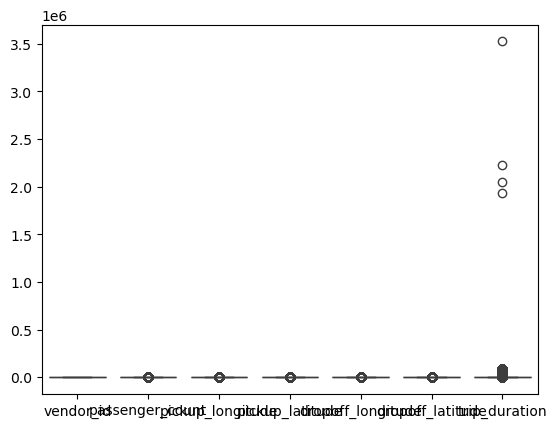

In [13]:
scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(df[continuous_features]), columns=continuous_features)
sns.boxplot(df)

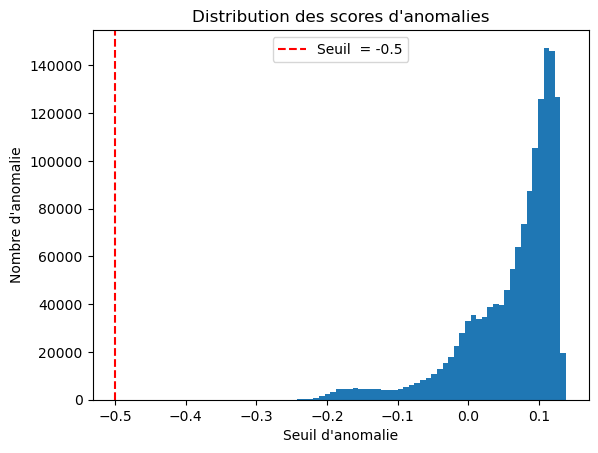

In [14]:
model = IsolationForest(random_state=0, contamination='auto')
model.fit(scaled_df)
outliers_predict = model.predict(scaled_df) == -1
anomaly_score = model.decision_function(scaled_df)

plt.hist(anomaly_score, bins=50)
plt.axvline(x=-0.5, color="red", linestyle="--", label="Seuil  = -0.5")
plt.title("Distribution des scores d'anomalies")
plt.xlabel("Seuil d'anomalie")
plt.ylabel("Nombre d'anomalie")
plt.legend()

In [15]:
z_scores = stats.zscore(scaled_df)
outliers = df[(np.abs(z_scores) > 3).any(axis=1)]

print("Nombres d'outliers (z-score) : ", len(outliers))

Nombres d'outliers (z-score) :  97459




---


## - Data Cleaning :    
- ### Renommer les colonnes : `df.rename(function, axis=1, inplace=true)` : `col.replace(a, b)` :  

- ### Supprimer les colonnes inutiles :    

In [3]:
df = df.drop("id", axis=1)

- ### Fusionner les colonnes redondantes :    

- ### Convertir les types des colonnes :   

In [4]:
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

df = df.astype({col : "float32" for col in continuous_features})

"""for col in df.select_dtypes("datetime").columns:
    df[f"{col.split("_")[0]}_month"] = df[col].dt.month.astype("object")
    df[f"{col.split("_")[0]}_weekday"] = df[col].dt.weekday.astype("object")
    df[f"{col.split("_")[0]}_day"] = df[col].dt.day.astype("object")
    df[f"{col.split("_")[0]}_hour"] = df[col].dt.hour.astype("object")"""

df["pickup_month"] = df["pickup_datetime"].dt.month.astype("object")
df["pickup_weekday"] = df["pickup_datetime"].dt.weekday.astype("object")
df["pickup_day"] = df["pickup_datetime"].dt.day.astype("object")
df["pickup_hour"] = df["pickup_datetime"].dt.hour.astype("object")
    
df["vendor_id"] = df["vendor_id"].astype("object")
df["passenger_count"] = df["passenger_count"].astype("object")

print(df.dtypes.value_counts())

object            7
float32           5
datetime64[ns]    2
Name: count, dtype: int64


- ### Gérer les valeurs manquantes :

- ### Gérer les outliers :

In [5]:
outliers = df[df["trip_duration"] > 1e6]
print(outliers.index)
df = df.drop(outliers.index, axis=0)

Index([355003, 680594, 924150, 978383], dtype='int64')




---


## **2. Exploration Uni-variable**
- ### Variables Continues (histogram, boxplot, scatterplot):
  - Skewness (>0.5 ou <-0.5) : `(décalé)` : toutes les features sont fortement asymétriques
  - Kurtosis (>5 ou ou <1) : `(forme applatie/pointue)` : aucune features n'a une forme normal
  - Variance (cv >1) : 'trip_duration' a une forte variance, les autres en ont une faible
  - Homoscedasticité (Breusch-Pagan >0.05) : p-value de 0.0, présence d'hétéroscedasticité à cause de 'trip_duration' (TARGET)
  - Observations : 
    - transformation mathématique et encodage pour régler les problèmes de skewness, kurtosis et variance
    - l'hétéroscedasticité de la target peut être ignoré
    - les scatter entre x et y donne tous le même résultat, possible multicolinéarité
    - 'trip_duration' possède 4 très important outliers, expliquant l'asymétrie et la variance

In [6]:
continuous_features = df.select_dtypes(include="float32").columns

skewness = df[continuous_features].skew().sort_values(ascending=False)
kurtosis = df[continuous_features].kurt().sort_values(ascending=False)
coef_var = df[continuous_features].std() / df[continuous_features].mean()
print(continuous_features)

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration'],
      dtype='object')


In [9]:
print(skewness)
print(kurtosis)
print(coef_var)

trip_duration        343.16
pickup_latitude        5.49
dropoff_latitude     -20.67
pickup_longitude    -418.12
dropoff_longitude   -425.33
dtype: float32
dropoff_longitude   292525.94
pickup_longitude    288156.50
trip_duration       192131.52
pickup_latitude      12950.24
dropoff_latitude      4259.54
dtype: float32
pickup_longitude    -0.02
pickup_latitude      0.01
dropoff_longitude   -0.02
dropoff_latitude     0.01
trip_duration        5.45
dtype: float32


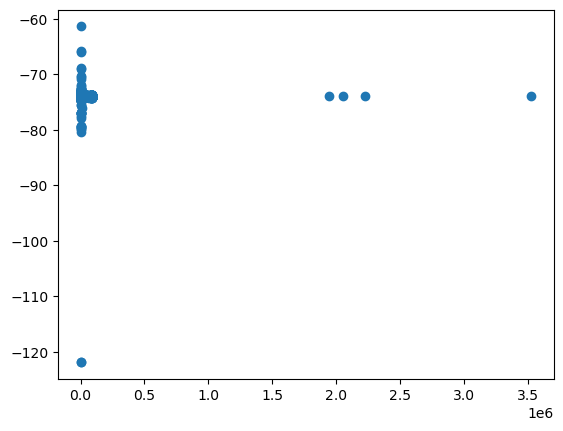

In [14]:
plt.scatter(df["trip_duration"], df["dropoff_longitude"])

<Axes: ylabel='dropoff_longitude'>

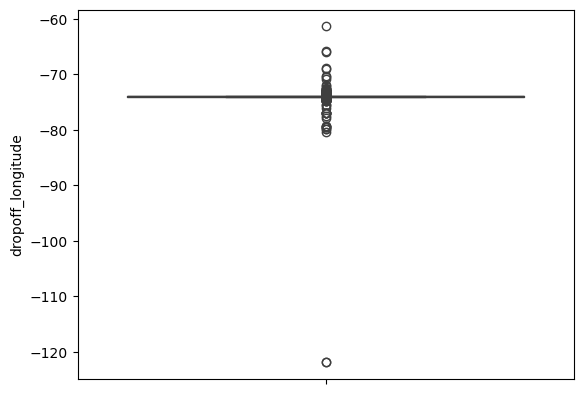

In [14]:
sns.boxplot(df["dropoff_longitude"])


<Axes: ylabel='trip_duration'>

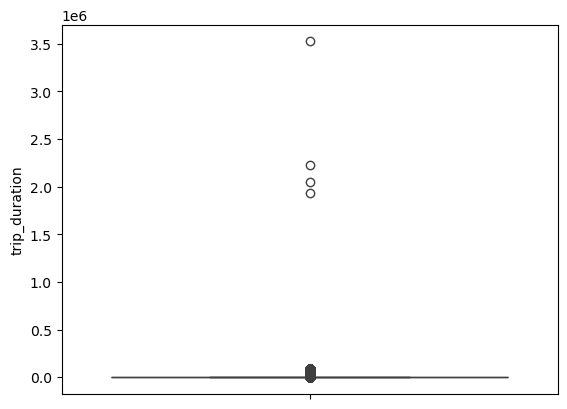

In [13]:
sns.boxplot(df["trip_duration"])

In [6]:
model = sm.OLS(df["trip_duration"], sm.add_constant(df[continuous_features])).fit() # Régression linéaire simple
residuals = model.resid # Résidus (erreurs)
y_pred = model.fittedvalues

In [10]:
test_statistic, p_value, _, _ = sms.het_breuschpagan(residuals, model.model.exog)
print("Statistique du test de Breusch-Pagan : ", test_statistic)
print("p-value : ", p_value)
print(model.summary())

Statistique du test de Breusch-Pagan :  945125.4489887301
p-value :  0.0
                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.496e+31
Date:                Wed, 05 Feb 2025   Prob (F-statistic):               0.00
Time:                        18:15:32   Log-Likelihood:             2.9417e+07
No. Observations:             1458644   AIC:                        -5.883e+07
Df Residuals:                 1458638   BIC:                        -5.883e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

Text(0.5, 1.0, 'Graphique des résidus vs valeurs prédites.')

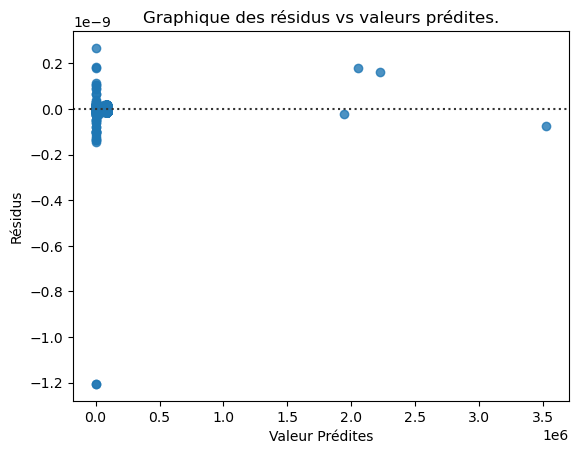

In [9]:
sns.residplot(x=y_pred, y=residuals, lowess=False, line_kws={"color": "red"}) # lowess : ajoute une courbe de régression lisse
plt.xlabel("Valeur Prédites")
plt.ylabel("Résidus")
plt.title("Graphique des résidus vs valeurs prédites.")

In [93]:
print(df[df["trip_duration"] > 1e6].index)

Index([], dtype='int64')


- ### Variables Catégorielles (barchat, countplot) :
  - Multiclasse : les autres
  - Binaire : 'store_and_fwd_flag'
  - Catégories dominantes :
    - store_and_fwd_flag : N est extrêmement majoritaire
    - passenger_count : 1
    - pickup_month : très minoritaire au 7ème mois (7), sûrement un manque de donnée
    - pickup_hour : minoritaire de 1 à 6h
  - Observations : 

In [7]:
categorial_features = df.select_dtypes(include="object").columns
print(categorial_features)

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pickup_month',
       'pickup_weekday', 'pickup_day', 'pickup_hour'],
      dtype='object')


<Axes: xlabel='store_and_fwd_flag', ylabel='count'>

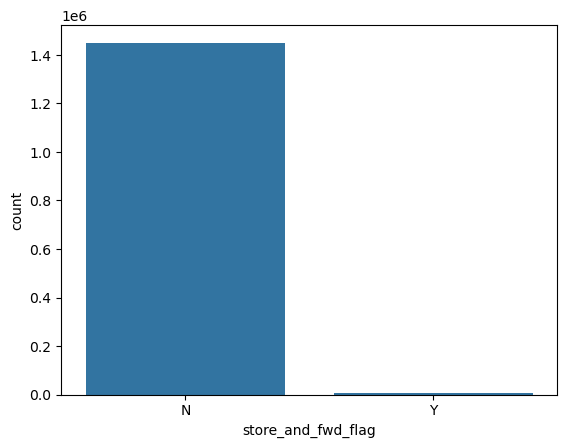

In [22]:
sns.countplot(x=df["store_and_fwd_flag"], data=df)

<Axes: xlabel='pickup_hour', ylabel='count'>

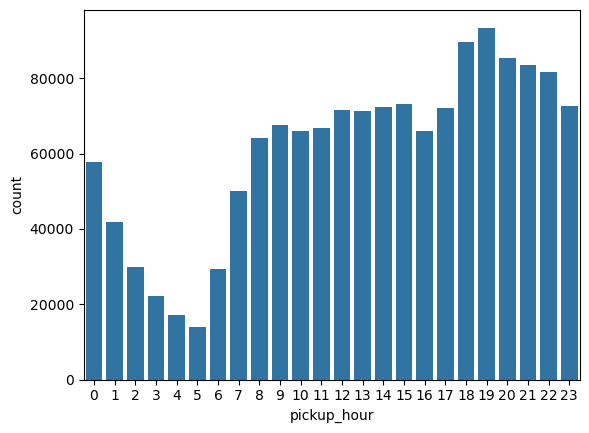

In [46]:
sns.countplot(x=df["pickup_hour"], data=df)

<Axes: xlabel='pickup_month', ylabel='count'>

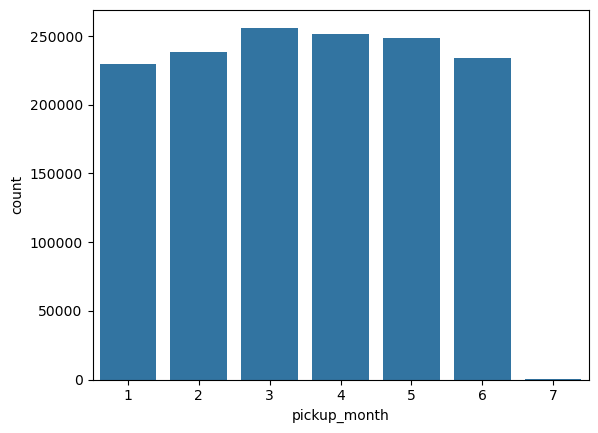

In [47]:
sns.countplot(x=df["pickup_month"], data=df)

<Axes: xlabel='pickup_weekday', ylabel='count'>

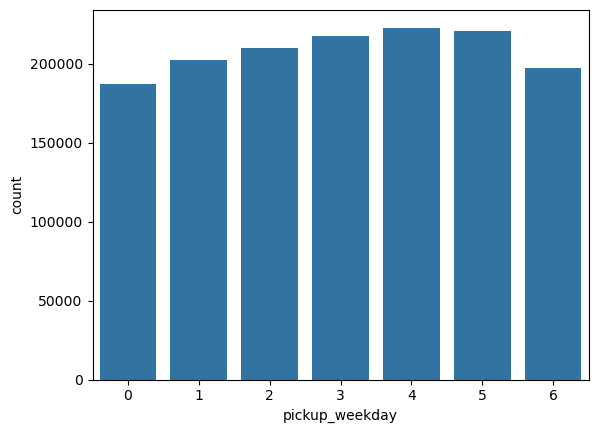

In [45]:
sns.countplot(x=df["pickup_weekday"], data=df)

<Axes: xlabel='passenger_count', ylabel='count'>

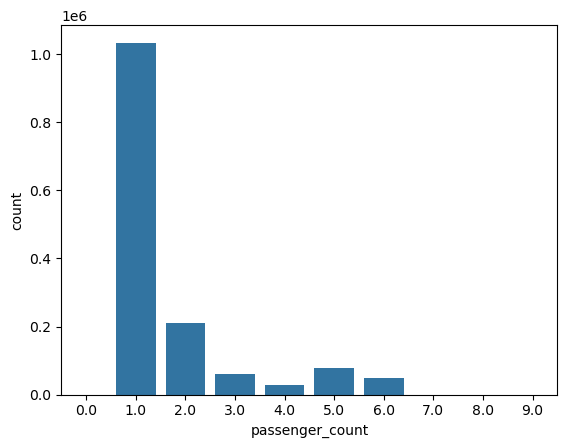

In [94]:
sns.countplot(x=df["passenger_count"], data=df)

## **3. Exploration Bi-variable**
- ### Variables Continues (scatterplot, matrice de corrélation) :
  - Corrélations :
    - pickup_latitude / dropoff_latitude : 80%
    - pickup_longitude / dropoff_longitude : 80%
    - pickup_latitude / dropoff_longitude : 50%
    - pickup_longitude / dropoff_latitude : 50%
  - Observations : 
    - latitude/latitude et longitude/longitude : il semble y avoir concentration de points de la même valeurs 
    - le scatter ne montre en réalité aucune relation entre latitude et longitude
    - aucune relation avec la target 'trip_duration'

In [87]:
print(continuous_features)

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration'],
      dtype='object')


In [8]:
continuous_corr = df[continuous_features].corr()

<Axes: >

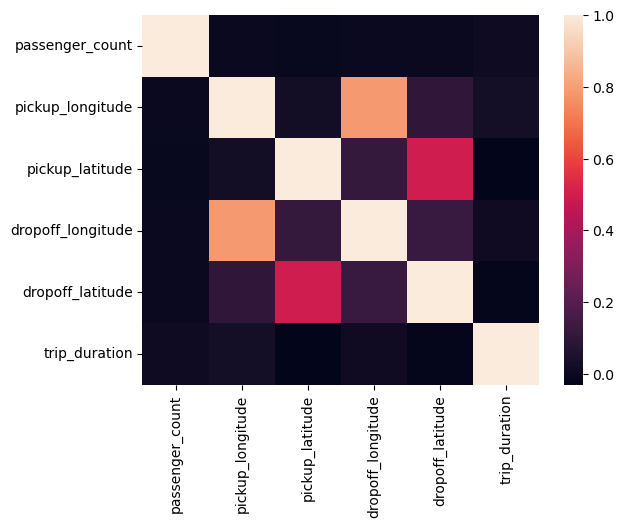

In [13]:
sns.heatmap(continuous_corr, cbar=True)

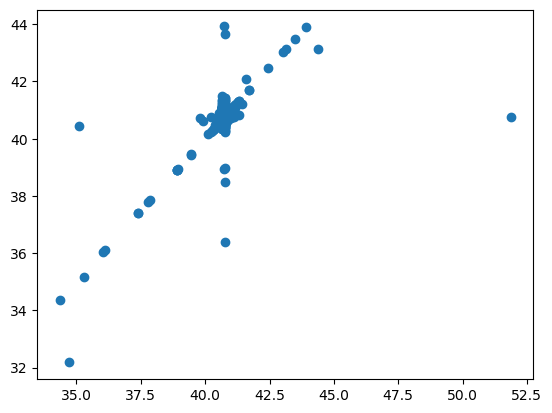

In [14]:
plt.scatter(df["pickup_latitude"], df["dropoff_latitude"])

<Axes: xlabel='pickup_longitude', ylabel='dropoff_longitude'>

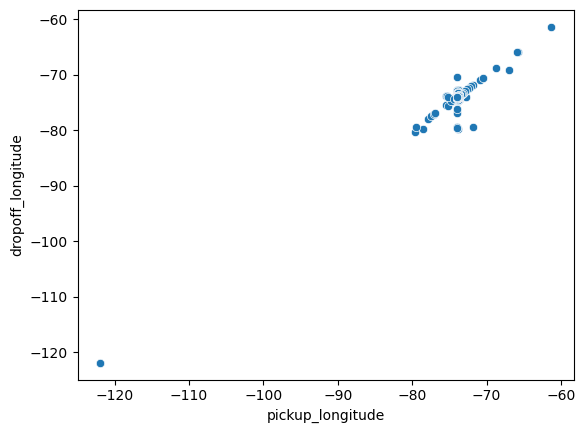

In [20]:
sns.scatterplot(x=df["pickup_longitude"], y=df["dropoff_longitude"])

<Axes: xlabel='pickup_longitude', ylabel='pickup_latitude'>

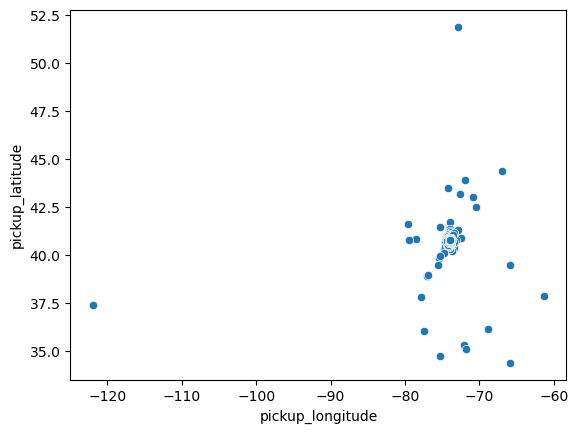

In [19]:
sns.scatterplot(x=df["pickup_longitude"], y=df["pickup_latitude"])

<Axes: xlabel='pickup_longitude', ylabel='trip_duration'>

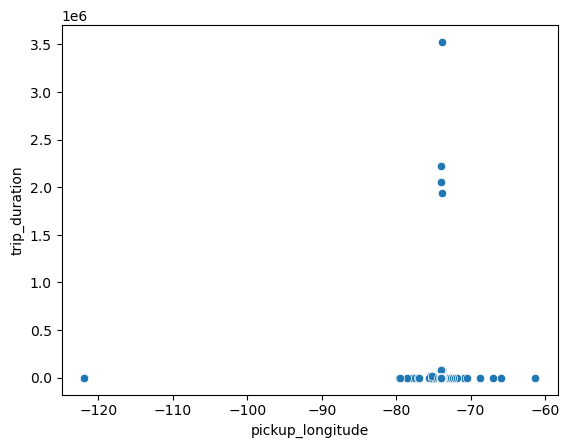

In [21]:
sns.scatterplot(x=df["pickup_longitude"], y=df["trip_duration"])

- ### Variables Continues et Catégorielles (boxplot, violonplot, barplot, heatmap, cramer's-v, PMF, PDF, CDF) :
  - Corrélations : 
    - vendor_id / trip_duration : '2' est un peu moins dispersé que '1' après la suppression des outliers de 'trip_duration'
    - pickup_hour / trip_duration : léger pic de durée de 11h à 17h
  - Skewness (>0.5 ou <-0.5) : `(décalé)` :
  - Variance (cv >1) : 
    - vendor_id / duration : '1' entre 0 et 1700, '2' entre 0 et '9000', mais forte concentration 'proche' de 0
    - passenger_count / trip_duration : valeur constantes de 'trip_duration' pour '7' (quasi), '8' et '9'
  - Observations :
    - vendor_id / trip_duration : semble avoir une quelconque corrélation avec les outliers (non important)
    - passenger_count / trip_duration : les classes 7, 8, 9 de 'passenger_count' pourrait être supprimé, elle sont des constantes. Il ne sembe pas y avoir de corrélation.
    - latitude et longitude semble n'avoir aucune corrélation avec aucune variable, à part entre elle
    - les datetimes n'ont pas grand intérêt avec les variables continues
    - store_and_fwd_flag : ne sert probablement à rien dû au déséquilibre extrème entre les 2 classes, + les variances et moyennes sont proche

In [88]:
print(continuous_features)
print(categorial_features)

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration'],
      dtype='object')
Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pickup_month',
       'pickup_weekday', 'pickup_day', 'pickup_hour'],
      dtype='object')


<Axes: xlabel='vendor_id', ylabel='trip_duration'>

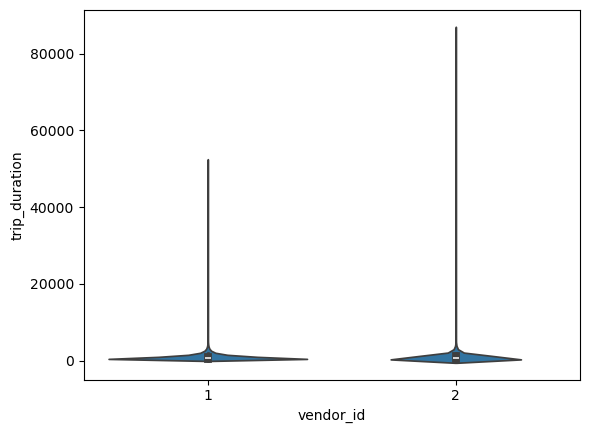

In [68]:
sns.violinplot(x=df["vendor_id"], y=df["trip_duration"])

<Axes: xlabel='vendor_id', ylabel='trip_duration'>

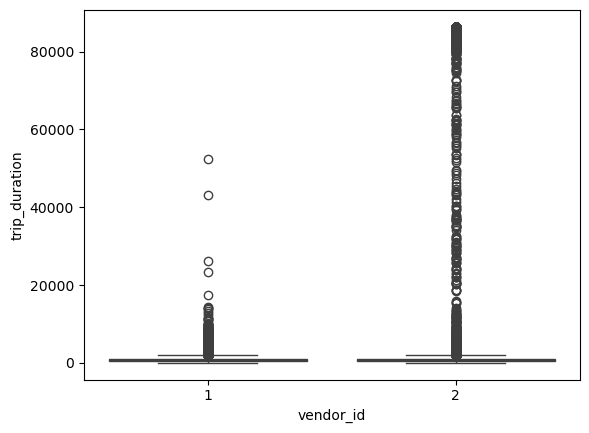

In [72]:
sns.boxplot(x=df["vendor_id"], y=df["trip_duration"], showfliers=True)

In [82]:
print(df.groupby("vendor_id")["trip_duration"].skew())
print(df.groupby("vendor_id")["trip_duration"].mean())

vendor_id
1    3.56
2   19.01
Name: trip_duration, dtype: float32
vendor_id
1    831.08
2   1058.64
Name: trip_duration, dtype: float32


<Axes: xlabel='vendor_id', ylabel='trip_duration'>

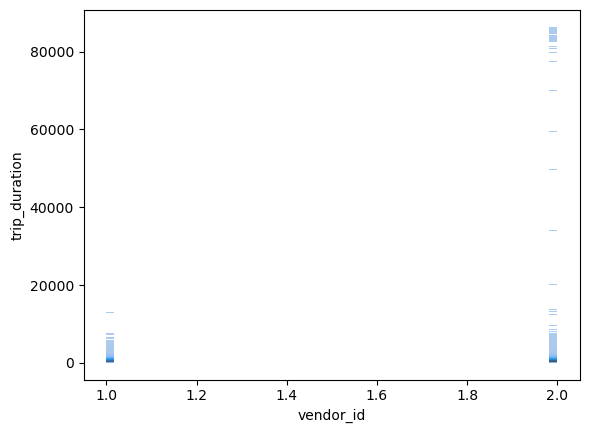

In [85]:
sns.histplot(x=df["vendor_id"], y=df["trip_duration"])

<Axes: xlabel='passenger_count', ylabel='trip_duration'>

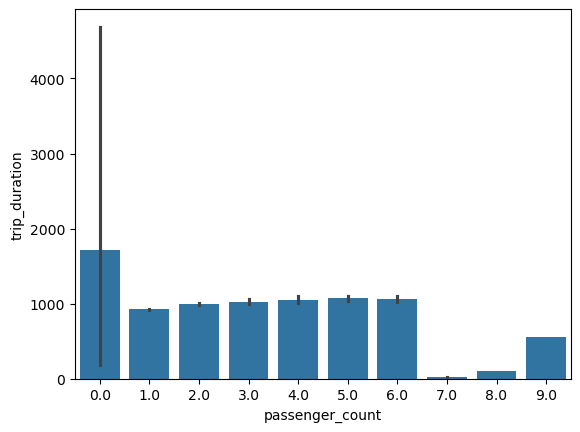

In [91]:
sns.barplot(x=df["passenger_count"], y=df["trip_duration"])

In [95]:
print(df.groupby("passenger_count")["trip_duration"].skew())
print(df.groupby("passenger_count")["trip_duration"].mean())
print(df.groupby("passenger_count")["trip_duration"].var())

passenger_count
0.00    7.70
1.00   27.23
2.00   24.89
3.00   21.79
4.00   21.40
5.00   18.63
6.00   18.67
7.00    0.59
8.00     NaN
9.00     NaN
Name: trip_duration, dtype: float32
passenger_count
0.00   1718.43
1.00    922.96
2.00    995.72
3.00   1028.24
4.00   1053.53
5.00   1070.23
6.00   1061.36
7.00     19.67
8.00    104.00
9.00    560.00
Name: trip_duration, dtype: float32
passenger_count
0.00   122592688.00
1.00     8542225.00
2.00    10256166.00
3.00    13828111.00
4.00    14361352.00
5.00    19179202.00
6.00    19098652.00
7.00          25.33
8.00            NaN
9.00            NaN
Name: trip_duration, dtype: float32


<Axes: xlabel='passenger_count', ylabel='trip_duration'>

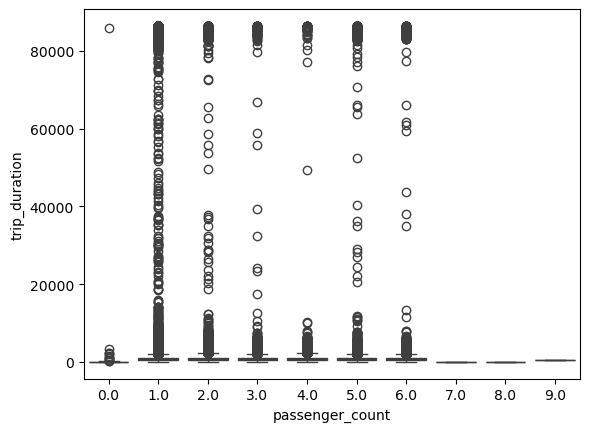

In [ ]:
sns.boxplot(x=df["passenger_count"], y=df["trip_duration"])

In [116]:
print(df.groupby("pickup_weekday")["trip_duration"].mean())
print(df.groupby("pickup_weekday")["trip_duration"].var())

pickup_weekday
0    897.95
1    962.92
2    975.45
3   1006.53
4    990.22
5    922.81
6    901.64
Name: trip_duration, dtype: float32
pickup_weekday
0    7668324.50
1    9350884.00
2    8430477.00
3    9610708.00
4   10723117.00
5   12357468.00
6   11942078.00
Name: trip_duration, dtype: float32


<Axes: xlabel='pickup_weekday', ylabel='trip_duration'>

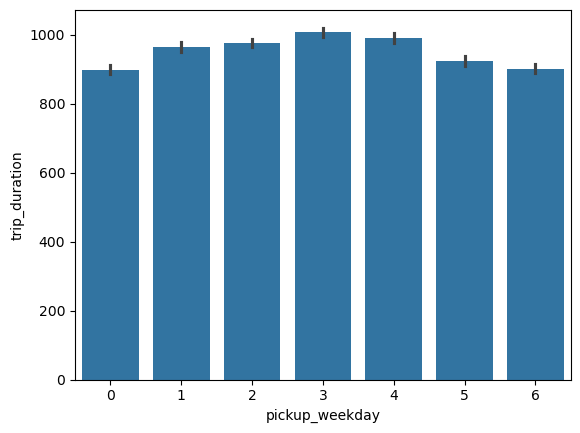

In [117]:
sns.barplot(x=df["pickup_weekday"], y=df["trip_duration"])

<Axes: xlabel='store_and_fwd_flag', ylabel='trip_duration'>

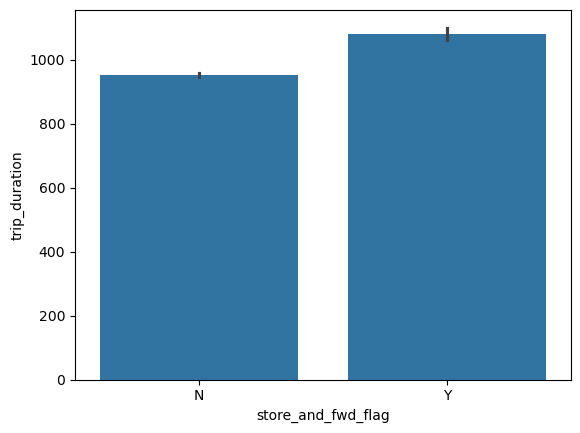

In [118]:
sns.barplot(x=df["store_and_fwd_flag"], y=df["trip_duration"])

In [119]:
print(df.groupby("store_and_fwd_flag")["trip_duration"].skew())
print(df.groupby("store_and_fwd_flag")["trip_duration"].mean())
print(df.groupby("store_and_fwd_flag")["trip_duration"].var())

store_and_fwd_flag
N   25.22
Y    2.03
Name: trip_duration, dtype: float32
store_and_fwd_flag
N    952.11
Y   1080.76
Name: trip_duration, dtype: float32
store_and_fwd_flag
N   10058413.00
Y     856819.56
Name: trip_duration, dtype: float32


<Axes: xlabel='store_and_fwd_flag', ylabel='trip_duration'>

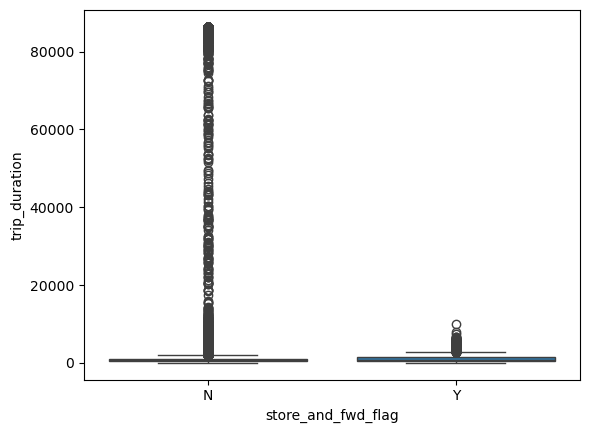

In [120]:
sns.boxplot(x=df["store_and_fwd_flag"], y=df["trip_duration"])

- ### Variables Catégorielles (boxplot, violonplot, barplot, heatmap, cramer's-v, PMF, CDF) :
  - Corrélations : 
    - passenger_count / vendor_id : 0.3 au test de Cramèr's v
    - pickup_day / pickup_weekday : 0.31
  - Observations :
    - 'pickup_weekday' et 'pickup_hour' pourrait avoir une légère corrélation avec 'passenger_count'
    - aucune corrélation flagrante avec 'store_and_fwd_flag' ne peut être trouvé, le déséquilibre de classe la rend inutilisable 

In [9]:
print(categorial_features)

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pickup_month',
       'pickup_weekday', 'pickup_day', 'pickup_hour'],
      dtype='object')


<Axes: xlabel='vendor_id', ylabel='passenger_count'>

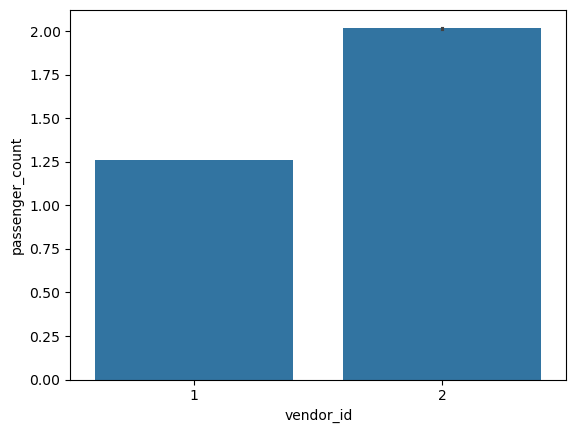

In [10]:
sns.barplot(x=df["vendor_id"], y=df["passenger_count"])

Text(0.5, 1.0, "Matrice de Cramér's V")

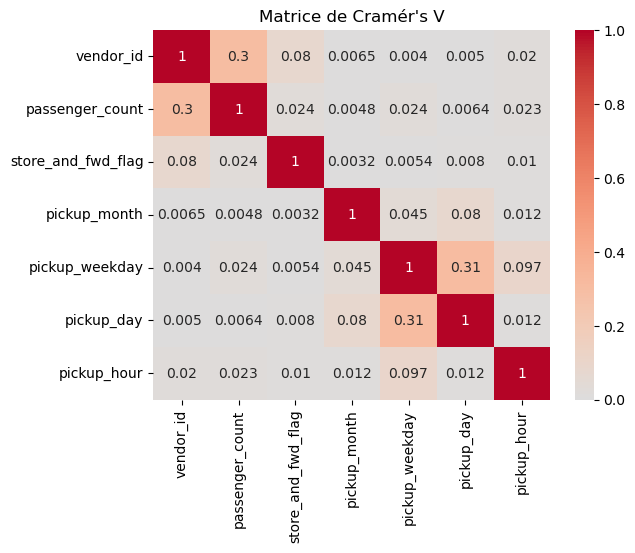

In [16]:
def cramers_v(chi2, n, k):
    """
    Calcule la valeur de Cramér's V à partir du chi2, du nombre total d'observations et des dimensions de la table de contingence
    """
    return np.sqrt(chi2 / (n * (min(k) - 1)))
def cramers_v_matrix(df, qualitative_vars):
    v_matrix = pd.DataFrame(index=qualitative_vars, columns=qualitative_vars) # matrice vide de colonne 'qualitative_vars' et de ligne 'qualitative_vars' 
    
    for var1 in qualitative_vars:
        for var2 in qualitative_vars:
            if var1 != var2:
                contingency_table = pd.crosstab(df[var1], df[var2])
                chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
                n = contingency_table.sum().sum() # nombre total d'observation
                k = contingency_table.shape
                v_matrix.loc[var1, var2] = cramers_v(chi2, n, k) # ajoute à la matrice, le test de cramer's v entre 'var1' et 'var2' (ligne et colonne)
            else:
                v_matrix.loc[var1, var2] = 1  # Cramér's V pour une variable avec elle-même est 1
    
    return v_matrix.astype(float)

matrix = cramers_v_matrix(df, categorial_features)

sns.heatmap(matrix, annot=True, cmap='coolwarm', center=0, vmin=0, vmax=1)
plt.title('Matrice de Cramér\'s V')

<Axes: xlabel='passenger_count', ylabel='pickup_weekday'>

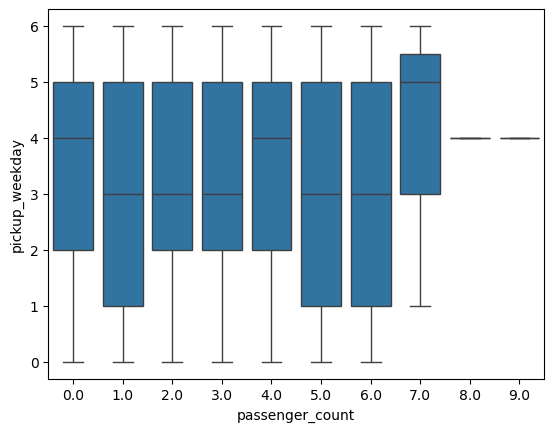

In [ ]:
sns.boxplot(x=df["passenger_count"], y=df["pickup_weekday"])

In [ ]:
print(df["passenger_count"].value_counts())

passenger_count
1.00    1033537
2.00     210317
5.00      78088
3.00      59896
6.00      48333
4.00      28404
0.00         60
7.00          3
9.00          1
8.00          1
Name: count, dtype: int64


<Axes: xlabel='passenger_count', ylabel='pickup_day'>

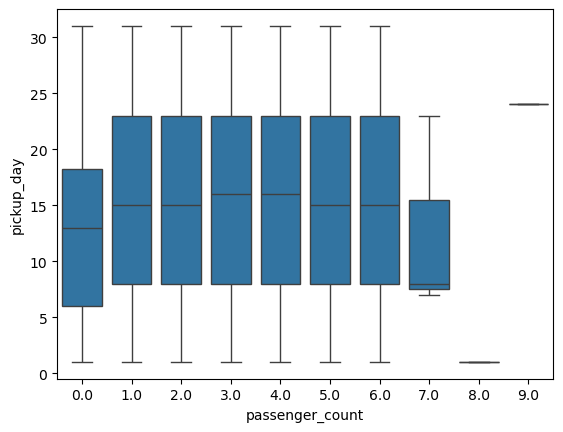

In [22]:
sns.boxplot(x=df["passenger_count"], y=df["pickup_day"])

<Axes: xlabel='store_and_fwd_flag', ylabel='pickup_weekday'>

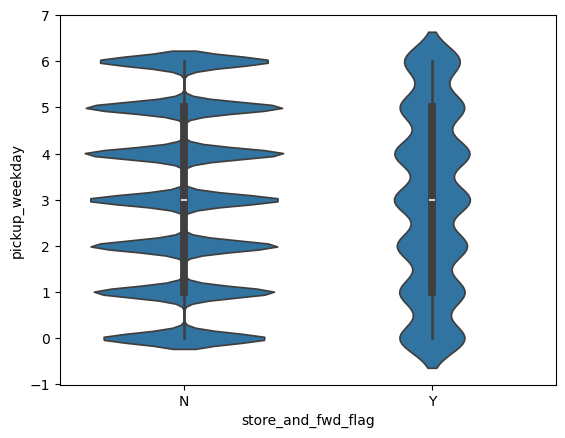

In [31]:
sns.violinplot(x=df["store_and_fwd_flag"], y=df["pickup_weekday"])

<Axes: xlabel='pickup_weekday', ylabel='passenger_count'>

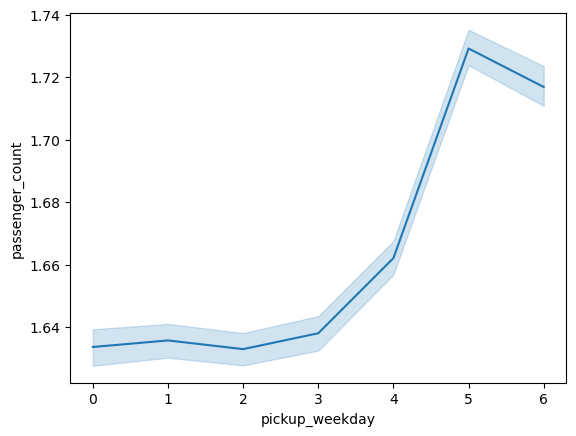

In [29]:
sns.lineplot(x=df["pickup_weekday"], y=df["passenger_count"])



---


## **4. Exploration Multi-variable**
- ### Variables Continues (scatterplot, matrice de corrélation) :
  - Corrélations : 
  - Observations :


- ### Variables Continues et Catégorielles (boxplot, violonplot, barplot, heatmap, cramer's-v, PMF, PDF, CDF) :
  - Corrélations : 
  - Observations :

- ### Variables Catégorielles (boxplot, violonplot, barplot, heatmap, cramer's-v, PMF, PDF, CDF) :
  - Corrélations : 
  - Observations :



---


## **5. Préparation des données pour la modélisation**
- ### Encodage :
  - ### Target :
  - ### Features :
- ### Transformation :
  - ### Feature Scaling :
  - ### Transformation Mathématique :
- ### Feature Engineering :